In [1]:
import pandas as pd
from pandas import json_normalize
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm

import nltk

import sys
from collections import defaultdict
from collections import Counter

import ds_utils_callum
import priv_policy_manipulation_functions as priv_pol_funcs

In [2]:
segment_annotations_df = pd.read_csv('segment_annotations.csv', sep = "ª", engine='python')

In [3]:
modelling_df = pd.read_csv('modelling_df.csv', sep = "ª", engine='python')

In [4]:
annotation_segment_frequencies = segment_annotations_df.iloc[:,7:].sum() # Number of paragraphs with each annotation

In [5]:
annotation_segment_frequencies.sort_values(ascending=False)[:10] # top 10 most regularly applied annotations

Contact_E_Mail_Address_1stParty               1111
Identifier_Cookie_or_similar_Tech_1stParty     861
Location_1stParty                              821
Identifier_IP_Address_1stParty                 591
Contact_Phone_Number_1stParty                  565
Identifier_Cookie_or_similar_Tech_3rdParty     525
Identifier_Device_ID_1stParty                  446
Contact_Postal_Address_1stParty                364
SSO                                            274
Demographic_Age_1stParty                       260
dtype: int64

In [6]:
segment_annotations_df.head()

,source_policy_number,policy_type,contains_synthetic,policy_segment_id,segment_text,annotations,sentences,Contact_1stParty,Contact_3rdParty,Contact_Address_Book_1stParty,...,Location_Bluetooth_1stParty,Location_Bluetooth_3rdParty,Location_Cell_Tower_1stParty,Location_Cell_Tower_3rdParty,Location_GPS_1stParty,Location_GPS_3rdParty,Location_IP_Address_1stParty,Location_IP_Address_3rdParty,Location_WiFi_1stParty,Location_WiFi_3rdParty
0,1,TEST,False,0,PRIVACY POLICY This privacy policy (hereafter ...,[],[],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,TEST,False,1,1. ABOUT OUR PRODUCTS 1.1 Our products offer a...,[],[],0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,TEST,False,2,2. THE INFORMATION WE COLLECT The information ...,[{'practice': 'Identifier_Cookie_or_similar_Te...,"[{'sentence_text': 'IP ADDRESS, COOKIES, AND W...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,TEST,False,3,"2.2 In addition, we store certain information ...",[{'practice': 'Identifier_Cookie_or_similar_Te...,"[{'sentence_text': '6677g may use cookies, web...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,TEST,False,4,(c) to remember your preferences and registrat...,[],[],0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
columns_of_interest = ['Contact_E_Mail_Address_1stParty', 'Contact_E_Mail_Address_3rdParty', 'Contact_Address_Book_1stParty', 
     'Contact_Postal_Address_3rdParty', 'Location_1stParty']

In [8]:
policies_have_annotations = segment_annotations_df.groupby('source_policy_number')[columns_of_interest].any()
policies_have_annotations

,Contact_E_Mail_Address_1stParty,Contact_E_Mail_Address_3rdParty,Contact_Address_Book_1stParty,Contact_Postal_Address_3rdParty,Location_1stParty
source_policy_number,,,,,
1,True,False,False,False,False
2,False,False,False,False,False
3,False,False,True,False,False
4,True,False,False,False,True
5,False,False,True,False,False
...,...,...,...,...,...
346,False,False,False,False,False
347,True,False,False,False,True
348,True,False,True,False,True


## What proportion of policies mention the practices of interest?

In [127]:
pol_annot_props = policies_have_annotations.mean()*100

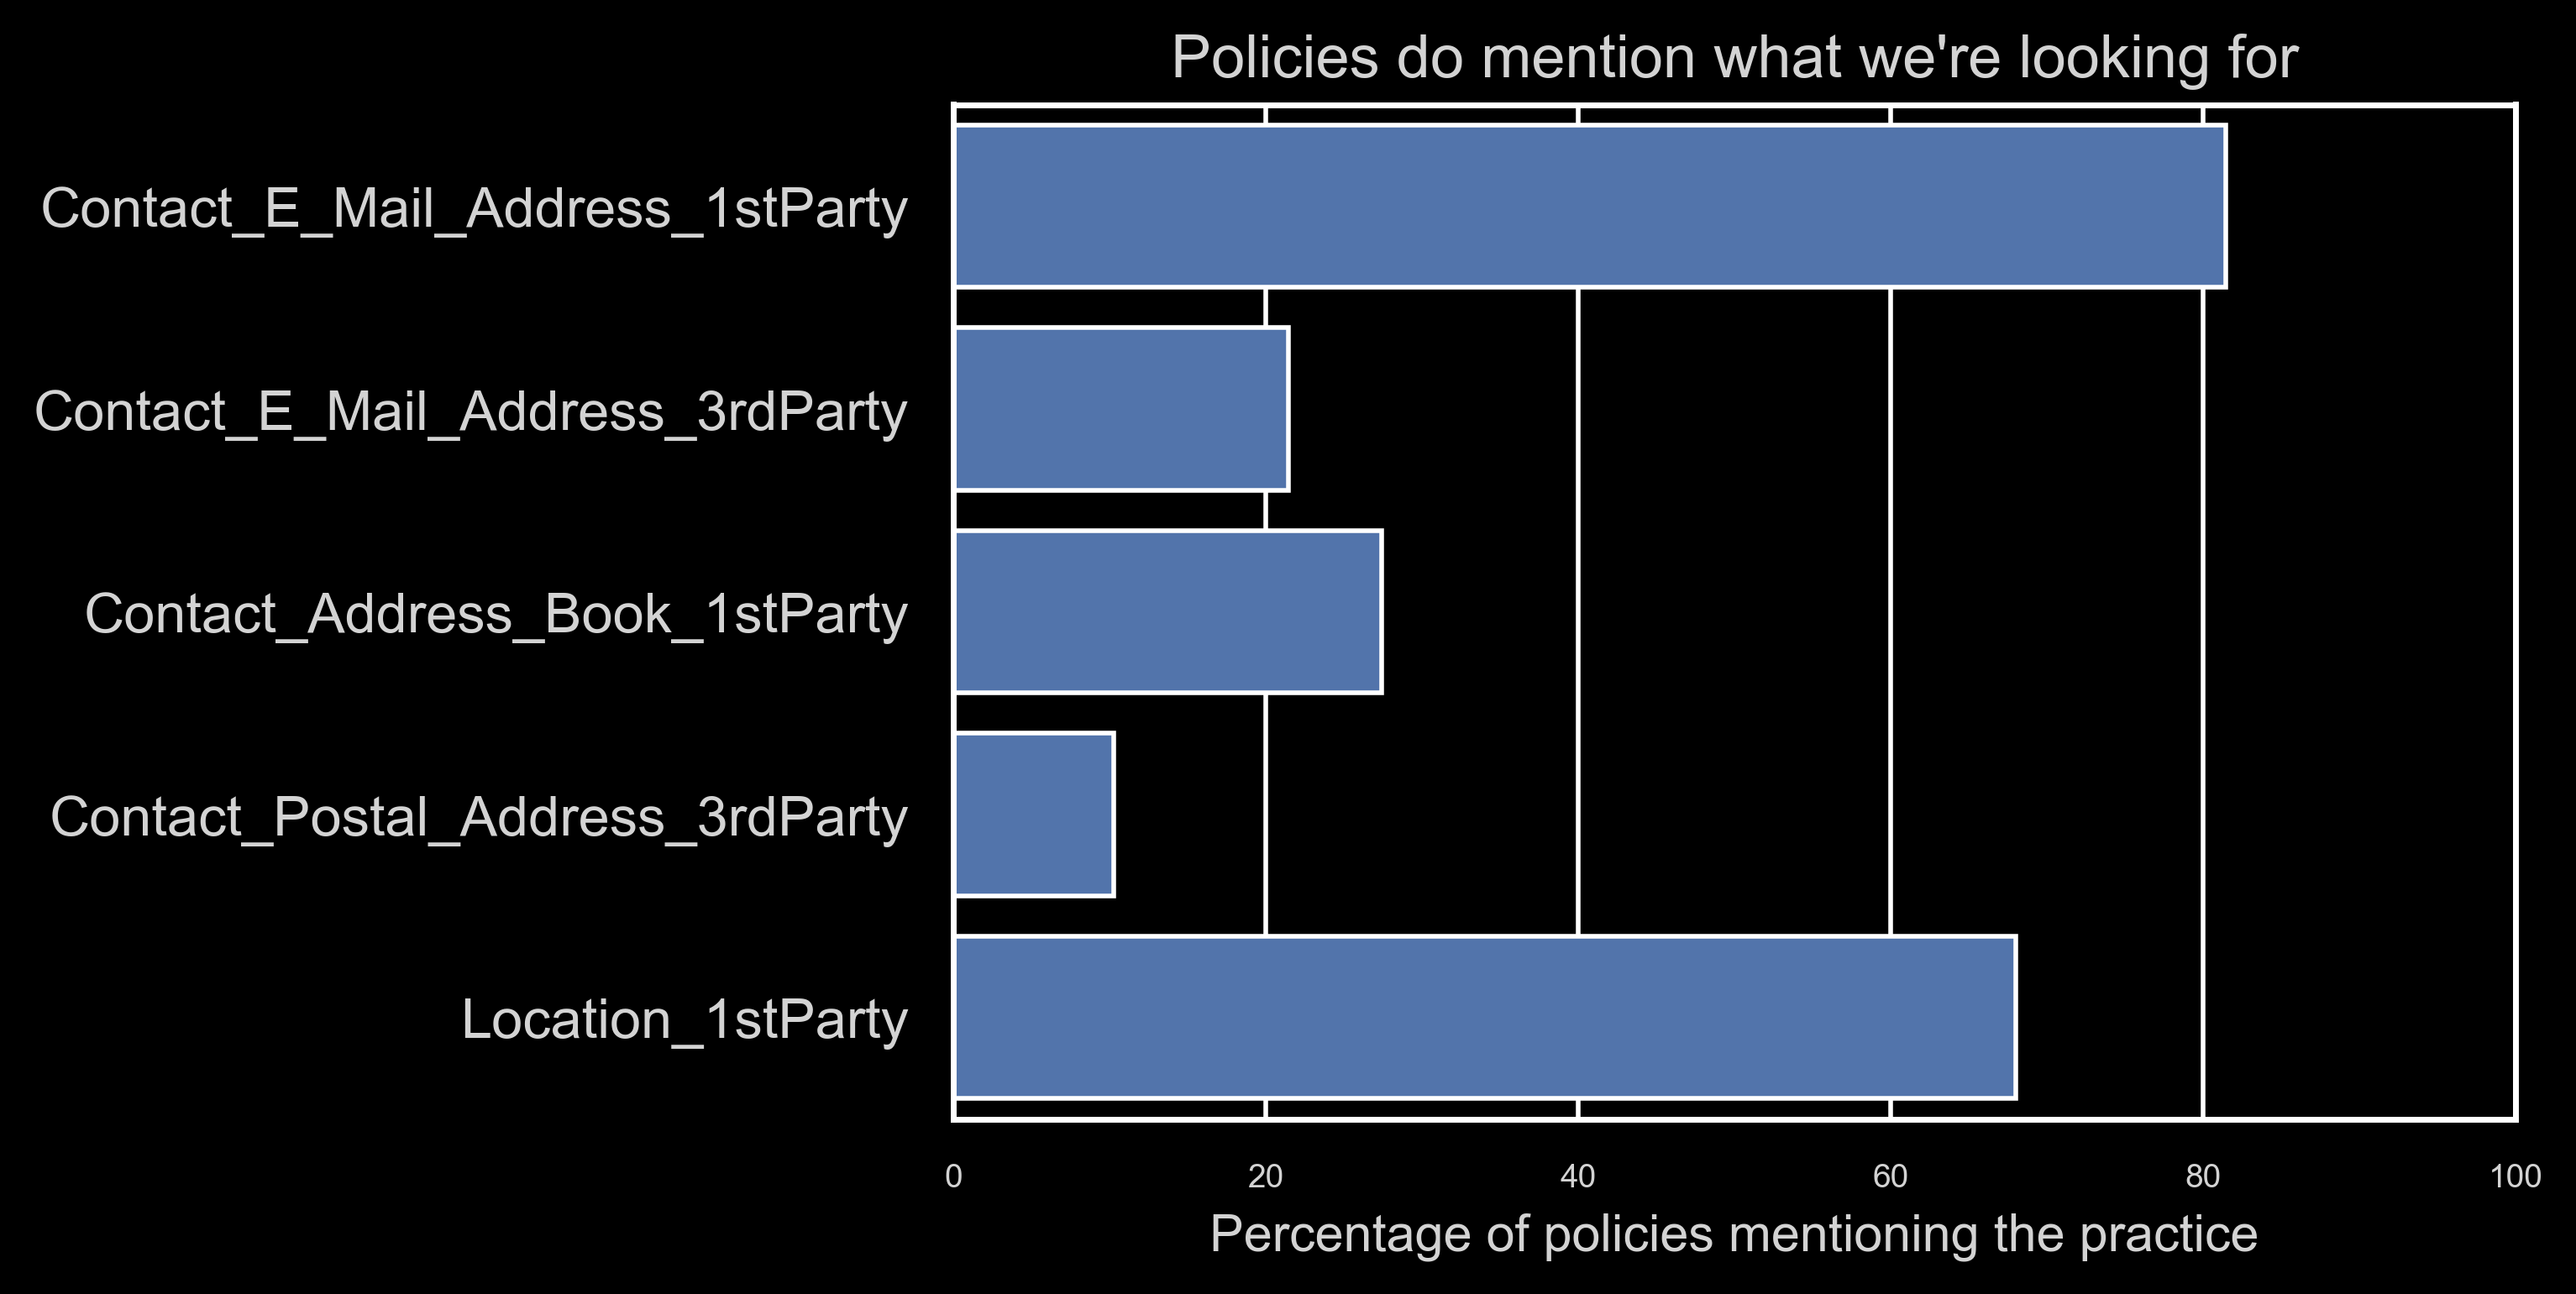

In [183]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.set_style("whitegrid", {})

plt.figure(figsize=(6,4), dpi=400)
sns.barplot(x=pol_annot_props.values, y=pol_annot_props.index, color='#4371ba')
plt.yticks(fontsize=12, c='lightgrey')
plt.xlabel("Percentage of policies mentioning the practice", fontsize=11, c='lightgrey')
plt.xticks(fontsize=7, c='lightgrey')
plt.xlim(0,100)
plt.title("Policies do mention what we're looking for", c='lightgrey', fontsize=13)
# sns.despine()
plt.show()

## What are the phrases most associated with practices of interest?

In [83]:
# modelling_df[modelling_df['Contact_E_Mail_Address_1stParty'] == 1]

In [161]:
top_5_quadragrams_one = priv_pol_funcs.get_top_ngrams(
    modelling_df[modelling_df['Contact_Address_Book_1stParty'] == 1]['sentence_text'], 5, top_n = 15)

In [162]:
quadragrams, gram_frequencies = map(list, zip(*top_5_quadragrams_one))

In [170]:
quadragrams[2:7]

['your contact list or address',
 'contact list or address book',
 'personally identifiable information such as',
 'identifiable information such as your',
 'your mobile device address book']

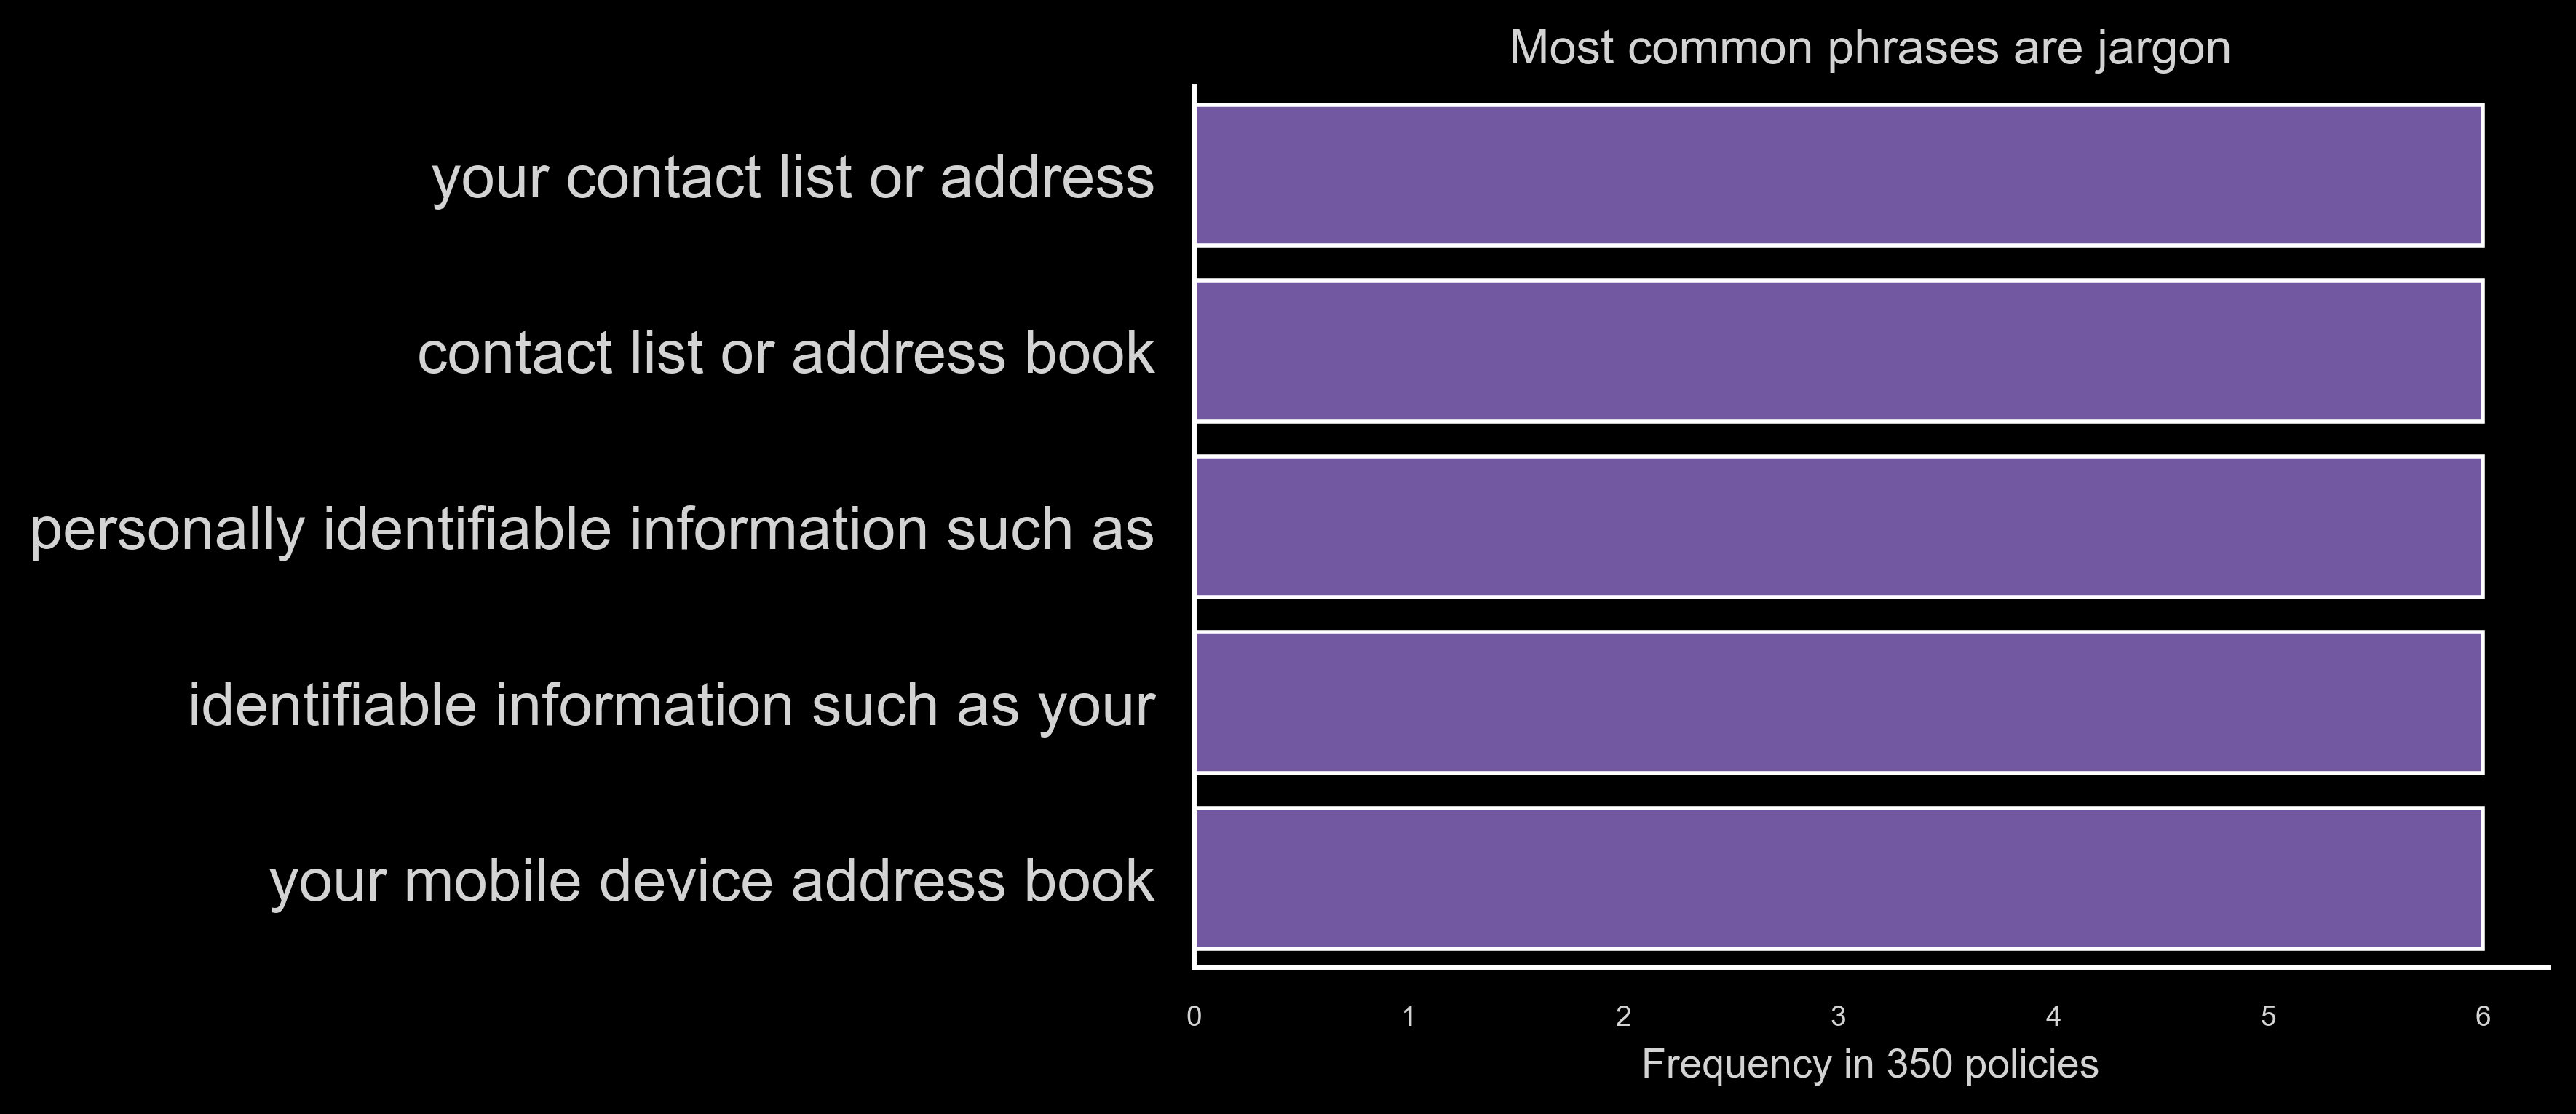

In [171]:
# plt.figure(figsize=(6,4), dpi=400)
# sns.barplot(x=gram_frequencies, y=quadragrams, color='black')
# plt.yticks(fontsize=9)
# plt.xlabel("Occurrence across 350 privacy policies", fontsize=8, c='lightgrey')
# plt.xticks(fontsize=7)
# plt.title("Top 5 quadra-grams")
# plt.show()

sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False})

plt.figure(figsize=(6,4), dpi=400)
sns.barplot(x=gram_frequencies[2:7], y=quadragrams[2:7], color = '#6d4cad')
plt.yticks(fontsize=15, c='lightgrey')
plt.xlabel("Frequency in 350 policies", fontsize=8, c='lightgrey')
plt.xticks(fontsize=7, c='lightgrey')
plt.title("Most common phrases are jargon", c='lightgrey')
sns.despine()
plt.show()

In [90]:
top_5_quadragrams_two = priv_pol_funcs.get_top_ngrams(
    modelling_df[modelling_df['Contact_E_Mail_Address_3rdParty'] == 1]['sentence_text'], n=5, top_n = 15)

In [91]:
quadragrams, gram_frequencies = map(list, zip(*top_5_quadragrams_two))

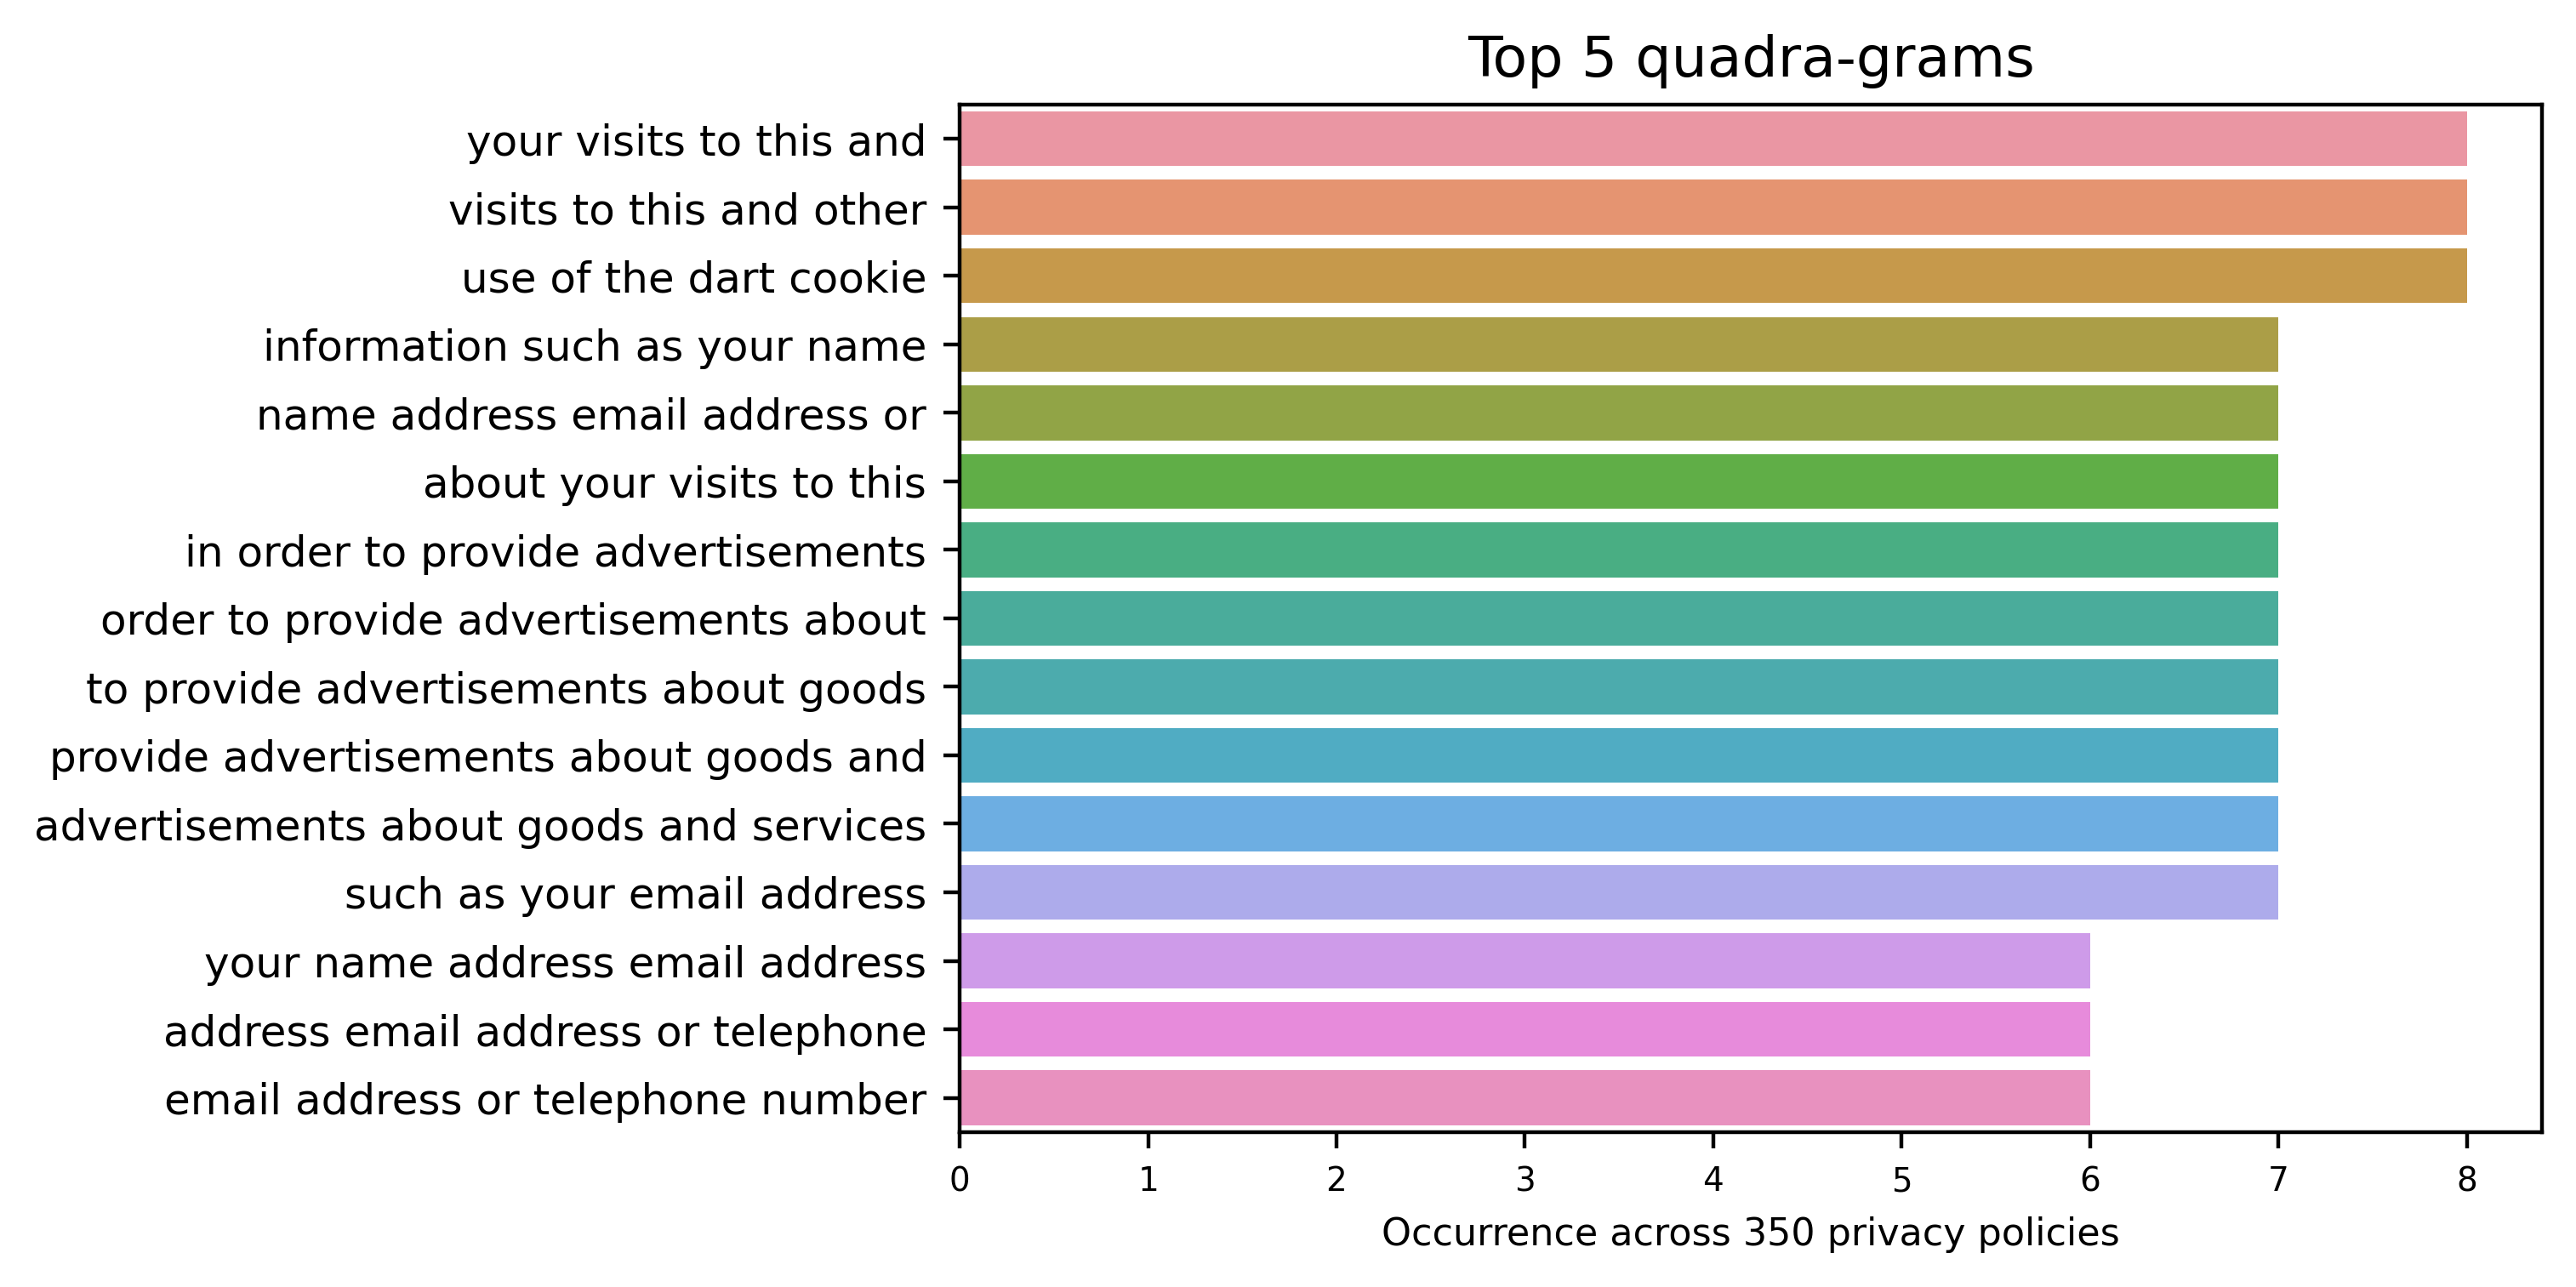

In [92]:
plt.figure(figsize=(6,4), dpi=400)
sns.barplot(x=gram_frequencies,y=quadragrams)
plt.yticks(fontsize=9)
plt.xlabel("Occurrence across 350 privacy policies", fontsize=8)
plt.xticks(fontsize=7)
plt.title("Top 5 quadra-grams")
plt.show()

## Overall top phrases

In [173]:
all_segments_df = pd.read_csv('all_segments_df.csv', sep = "ª", engine='python')

In [174]:
top_5_all_phrases = priv_pol_funcs.get_top_ngrams(
    all_segments_df['segment_text'], n=6, top_n = 5)
quadragrams, gram_frequencies = map(list, zip(*top_5_all_phrases))

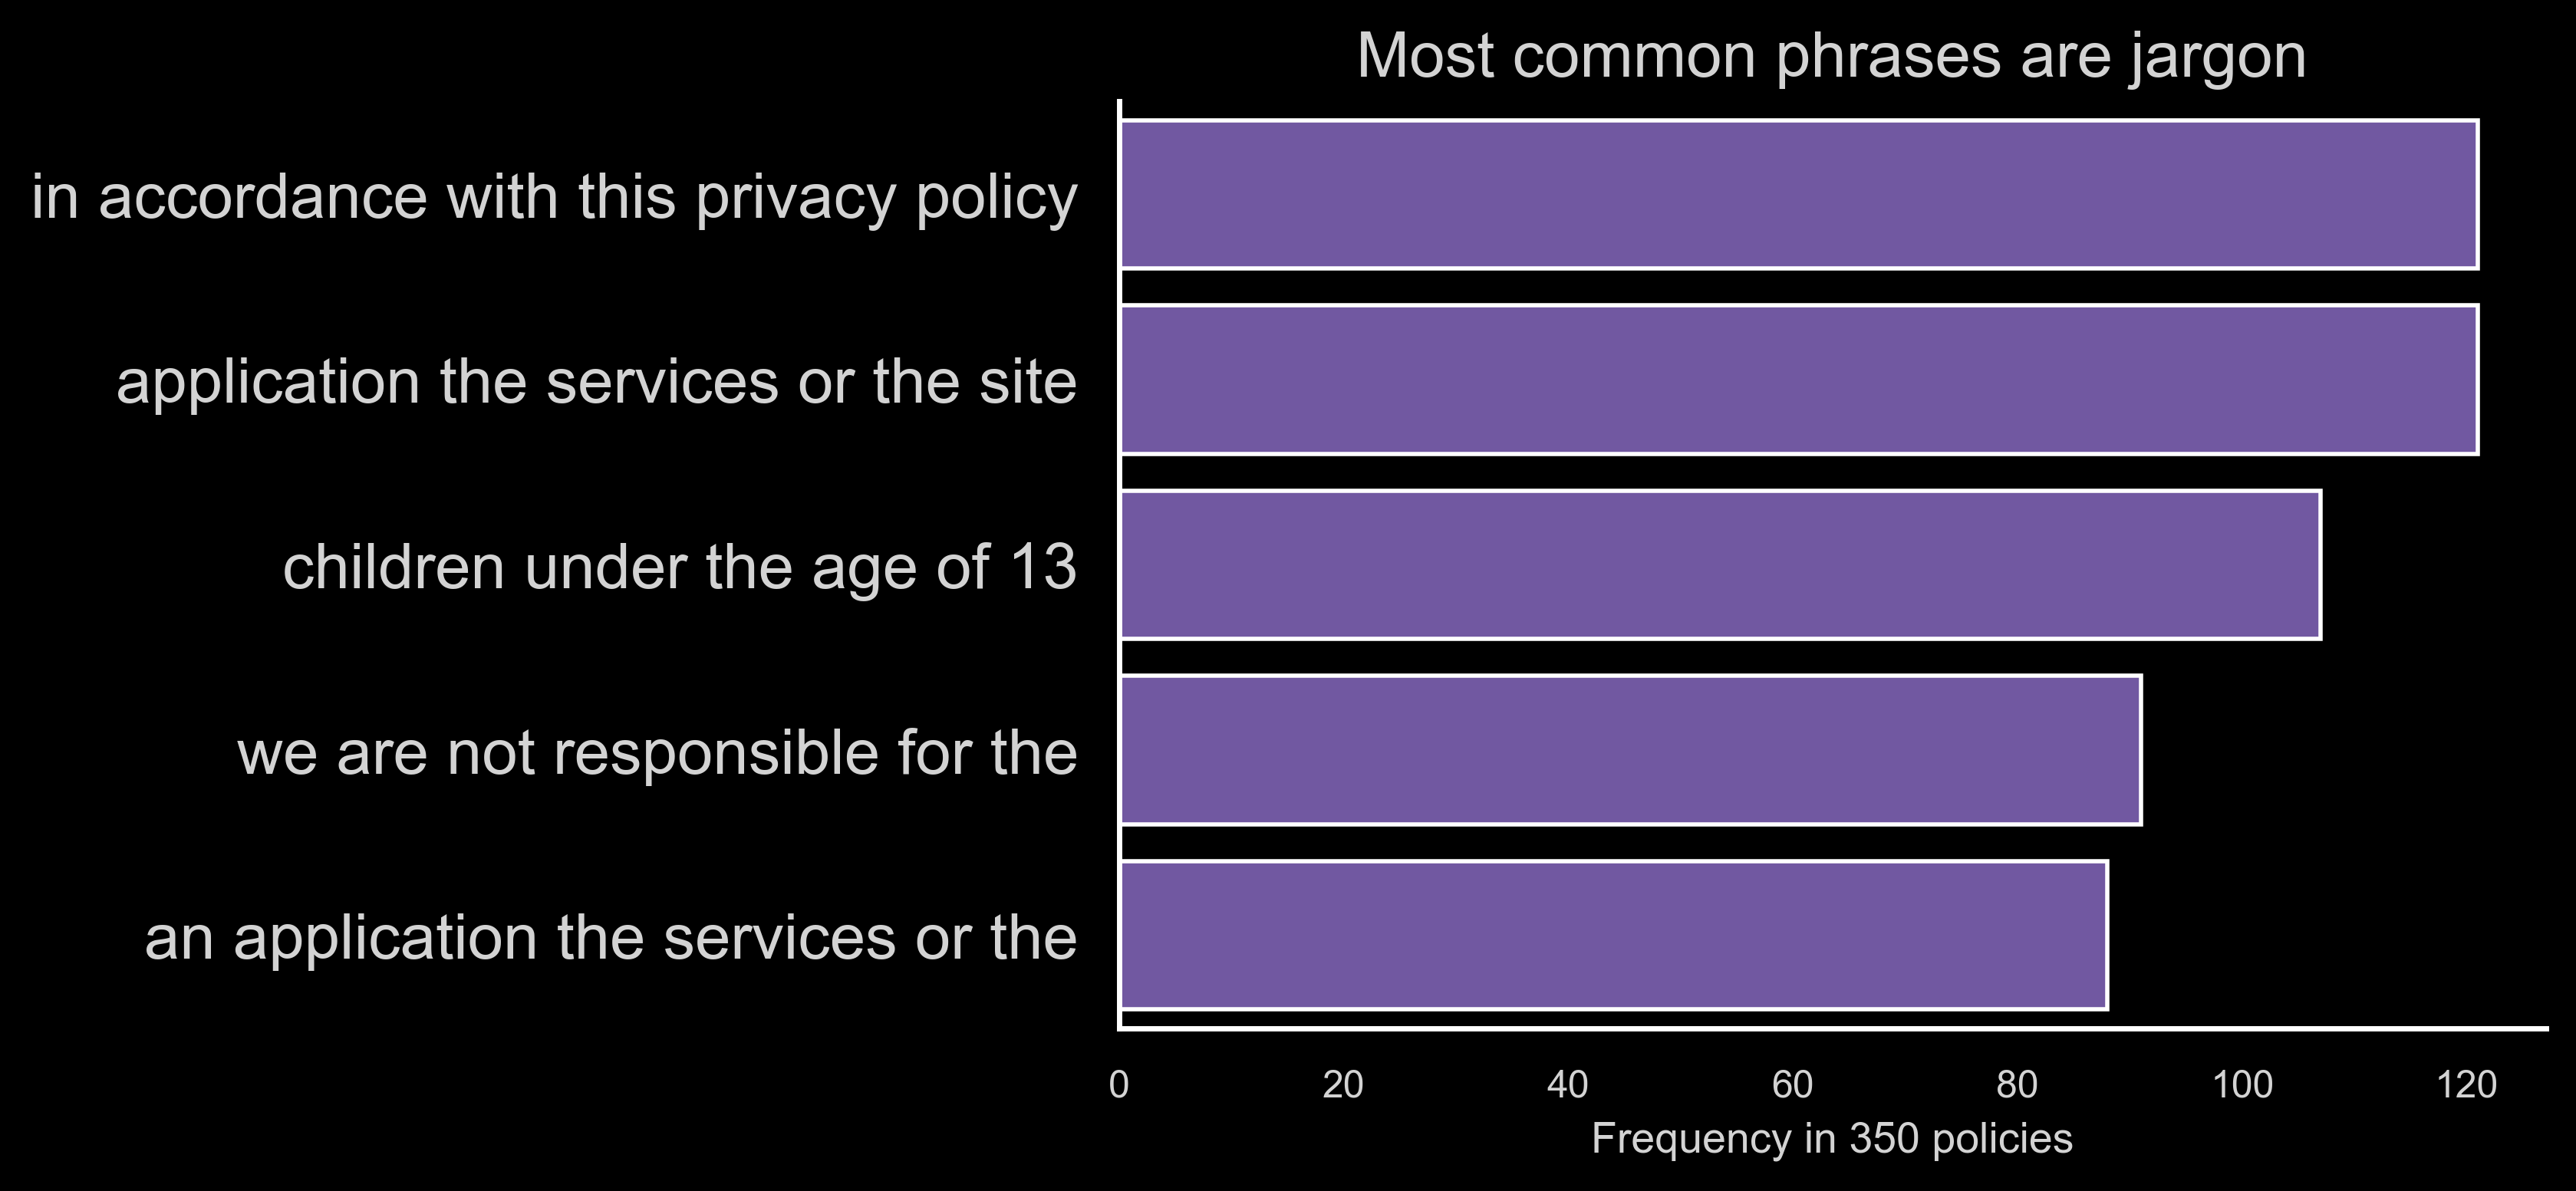

In [179]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False})
# sns.set_style("whitegrid", {})

plt.figure(figsize=(6,4), dpi=400)
sns.barplot(x=gram_frequencies, y=quadragrams, color = '#6d4cad')
plt.yticks(fontsize=15, c='lightgrey')
plt.xlabel("Frequency in 350 policies", fontsize=10, c='lightgrey')
plt.xticks(fontsize=9, c='lightgrey')
plt.title("Most common phrases are jargon", c='lightgrey', fontsize=15)
sns.despine()
plt.show()

In [109]:
plt.figure(figsize=(6,4), dpi=400)
plt.bar(x=gram_frequencies, y=quadragrams)
plt.yticks(fontsize=9, c='white')
plt.xlabel("Frequency in 350 policies", fontsize=8, c='white')
plt.xticks(fontsize=7, c='white')
plt.title("Most common phrases", c='white')
plt.show()

TypeError: barh() missing 1 required positional argument: 'width'

<Figure size 2400x1600 with 0 Axes>